In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [5]:
!kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

 99% 1.13G/1.14G [00:19<00:00, 53.3MB/s]
100% 1.14G/1.14G [00:19<00:00, 63.9MB/s]


In [6]:
import zipfile
zf = "/content/pneumonia-xray-images.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [8]:
train_path = '/content/dataset/cnn/pneumonia_revamped/train'
test_path = '/content/dataset/cnn/pneumonia_revamped/test'
valid_path = '/content/dataset/cnn/pneumonia_revamped/val'

In [51]:
batch_size = 48

img_height = 150
img_width = 150

In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(rescale=1./255,zoom_range=0.4,shear_range=0.3,horizontal_flip=True)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [53]:
train = image_gen.flow_from_directory(train_path,target_size=(img_height,img_width),class_mode='binary',batch_size=batch_size)
test = test_data_gen.flow_from_directory(test_path,target_size=(img_height,img_width),shuffle=False,class_mode='binary',batch_size=batch_size)
valid = test_data_gen.flow_from_directory(valid_path,target_size=(img_height,img_width),class_mode='binary',batch_size=batch_size)

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


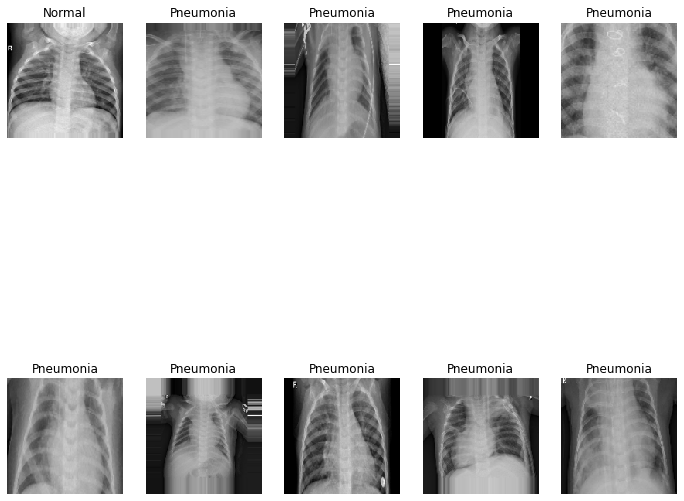

In [54]:
plt.figure(figsize=(12,12))
for i in range(0,10):
  plt.subplot(2,5,i+1)
  for X_batch,Y_batch in train:
    image = X_batch[0]
    dic = {0:'Normal',1:'Pneumonia'}
    plt.title(dic.get(Y_batch[0]))
    plt.axis('off')

    plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
    break

    plt.tight_layout()
    plt.show()

In [55]:
import keras
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, BatchNormalization

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [56]:
model = Sequential()

model.add(Conv2D(32,(3,3),input_shape=(img_width,img_height,3),kernel_initializer='he_normal'))
model.add(keras.layers.ELU())
model.add(BatchNormalization())

model.add(Conv2D(32,(3,3),kernel_initializer='he_normal'))
model.add(keras.layers.ELU())
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),kernel_initializer='he_normal'))
model.add(keras.layers.ELU())
model.add(BatchNormalization())

model.add(Conv2D(64,(3,3),kernel_initializer='he_normal'))
model.add(keras.layers.ELU())
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),kernel_initializer='he_normal'))
model.add(keras.layers.ELU())
model.add(BatchNormalization())

model.add(Conv2D(128,(3,3),kernel_initializer='he_normal'))
model.add(keras.layers.ELU())
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Dropout(0.2))

model.add(Conv2D(256,(3,3),kernel_initializer='he_normal'))
model.add(keras.layers.ELU())
model.add(BatchNormalization())

model.add(Conv2D(256,(3,3),kernel_initializer='he_normal'))
model.add(keras.layers.ELU())
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128))

model.add(keras.layers.ELU())

model.add(BatchNormalization())

model.add(Dropout(0.75))

model.add(Dense(activation='sigmoid',units=1))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [57]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
elu_36 (ELU)                 (None, 148, 148, 32)      0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 148, 148, 32)      128       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 146, 146, 32)      9248      
_________________________________________________________________
elu_37 (ELU)                 (None, 146, 146, 32)      0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 146, 146, 32)      128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 73, 73, 32)       

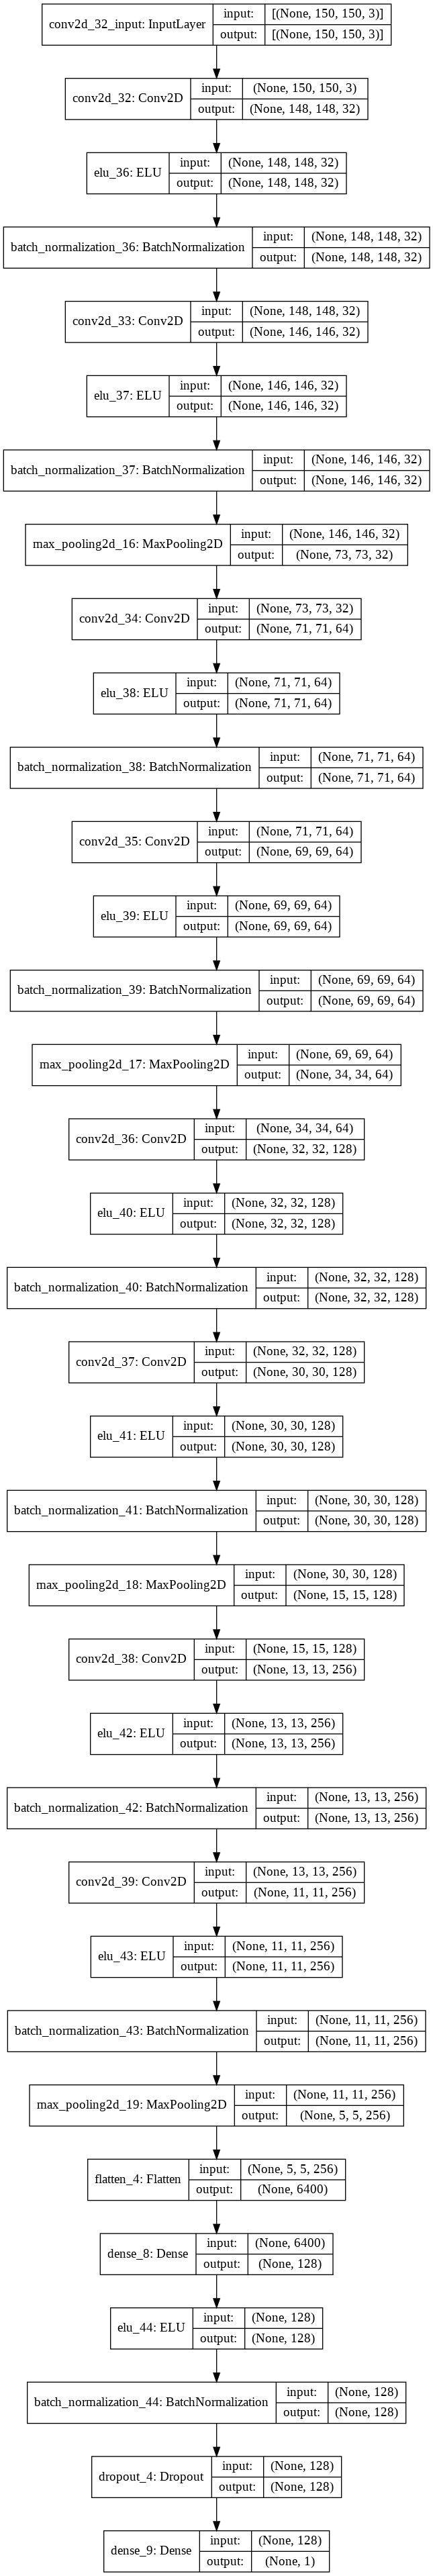

In [58]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True,show_layer_names=True,rankdir='TB',expand_nested=True)

In [59]:
early = EarlyStopping(monitor="val_loss",mode="min",patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',patience=2,verbose=1,factor=0.3,min_lr=0.000001)
callbacks_list = [early,learning_rate_reduction]

In [60]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',np.unique(train.classes),train.classes)
cw = dict(zip(np.unique(train.classes),weights))
print(cw)

{0: 1.9371534195933457, 1: 0.6739549839228296}


In [ ]:
model.fit(train,epochs=25,validation_data=valid,class_weight=cw,batch_size=512,callbacks=callbacks_list)

Epoch 1/25
88/88 [==============================] - 771s 9s/step - loss: 0.6952 - accuracy: 0.7322 - val_loss: 0.8615 - val_accuracy: 0.7519
Epoch 2/25
52/88 [================>.............] - ETA: 4:50 - loss: 0.3784 - accuracy: 0.8400

In [ ]:
pd.DataFrame(model.history.history).plot()

In [ ]:
test_accu = model.evaluate(test)
print('The testing accuracy is - ',test_accu[1]*100,'%')